In [1]:
# do not show warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import json
import pickle
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
from keras.preprocessing import sequence
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Using TensorFlow backend.


In [3]:
PATH_POS = "dataset/aclImdb/train/pos/"
PATH_NEG = "dataset/aclImdb/train/neg/"
PATH_POS_TEST = "dataset/aclImdb/test/pos/"
PATH_NEG_TEST = "dataset/aclImdb/test/neg/"

TOKENIZER_FILE = "tokenizer_Yelp_keras_stars.pkl"
PRETRAINED_MODEL = "yelp_starts_keras_10ep.h5"

NB_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001
VAL_SPLIT = 0.2

VOC_SIZE = 10000
MIN_WORDS = 20
MAX_WORDS = 100

In [4]:
def read_file(path):
    """ Read the file and remove the return line character"""
    with open(path, 'r') as file:
        reviews = file.read().replace('\n', '')
    return reviews
        

def create_df(path):
    """ Create a dataframe with columns: 'reviews', 'ids', 'ratings' """
    reviews = [read_file(path + file_name)  for file_name in os.listdir(path)]
    ids = [file_name.partition("_")[0] for file_name in os.listdir(path)] 
    ratings = [file_name.partition("_")[2][:-4] for file_name in os.listdir(path)]
    
    df = pd.DataFrame(list(zip(reviews, ids, ratings)), columns=['reviews','ids', 'ratings'])
    df['reviews'] = df.reviews.str.replace('<br /><br />' , '')
    
    return df

In [5]:
print("Loading the data...")
df_pos_train  = create_df(PATH_POS)
df_pos_test = create_df(PATH_POS_TEST)

df_neg_train = create_df(PATH_NEG)
df_neg_test = create_df(PATH_NEG_TEST)

# create a single dataframe for training and testing
df_train = df_neg_train.append(df_pos_train, ignore_index=True)
df_test = df_neg_test.append(df_pos_test, ignore_index=True)
print("Train set size: ", len(df_train))
print("Test set size: ", len(df_test))

Loading the data...
Train set size:  25000
Test set size:  25000


In [6]:
# shuffle the date in-place and reset the index
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [7]:
# change rating type to integer 
df_train.ratings = df_train.ratings.astype(int)
df_test.ratings = df_test.ratings.astype(int)

-  positive reviews:  > 6 stars
-  negative reviews:  < 5 stars

1 = positive review, 0 = negative review



In [8]:
X = df_train.reviews
y = df_train.ratings.replace([1,2,3,4],0).replace([7,8,9,10],1)
X.shape, y.shape

((25000,), (25000,))

In [9]:
X_test = df_test.reviews
y_test = df_test.ratings.replace([1,2,3,4],0).replace([7,8,9,10],1)
X_test.shape, y_test.shape

((25000,), (25000,))

In [14]:
def check_balaced_dataset(y):
    """ Check if a dataset is balanced """
    pos_samples = y[y == 1]
    neg_samples = y[y == 0]
    
    if(len(pos_samples) == len(neg_samples)):
        print("\tThe dataset is balanced.")
    else:
        print("\tThe dataset is unbalanced.")

In [15]:
# check if the set is balanced
print("Train set:")
check_balaced_dataset(y)

print("\nTest set:")
check_balaced_dataset(y_test)

Train set:
	The dataset is balanced.

Test set:
	The dataset is balanced.


In [16]:
def load_pickle_file(filename):
    """ Load a pickle file """
    with open(filename, 'rb') as input:
        tokenizer = pickle.load(input)
    return tokenizer

In [17]:
def text_to_seq(X, max_lenght):
    """ Convert text to padded sequence with max lenght"""
    sequences = tokenizer.texts_to_sequences(X)
    sequences = sequence.pad_sequences(sequences, maxlen=max_lenght)
    return sequences

In [18]:
tokenizer = load_pickle_file(TOKENIZER_FILE)
X = text_to_seq(X, MAX_WORDS)
print("Train set shape: ", X.shape)

Train set shape:  (25000, 100)


In [25]:
def plot_accuracy(history):
    """ Plot the accurary vs epoch for the train and validation set"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
def plot_loss(history):
    """ Plot the loss vs epoch for the train and validation set"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

## Base line model

In [22]:
print("Base line model: \n")
base_line = Sequential()
base_line.add(Embedding(VOC_SIZE, 128, input_length=MAX_WORDS))
base_line.add(Bidirectional(LSTM(64)))
base_line.add(Dropout(0.5))
base_line.add(Dense(1, activation='sigmoid'))
base_line.summary()

Base line model: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [23]:
keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
base_line.compile(optimizer, 
              'binary_crossentropy', 
              metrics=['accuracy'])

In [24]:
# train the model
history_base_line = base_line.fit(X, y,
                                  batch_size=BATCH_SIZE,
                                  epochs=NB_EPOCHS,
                                  validation_split=VAL_SPLIT)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 43s 2ms/step - loss: 0.4460 - acc: 0.7842 - val_loss: 0.3467 - val_acc: 0.8496
Epoch 2/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.2878 - acc: 0.8817 - val_loss: 0.3466 - val_acc: 0.8504
Epoch 3/10
20000/20000 [==============================] - 48s 2ms/step - loss: 0.2281 - acc: 0.9122 - val_loss: 0.3561 - val_acc: 0.8466
Epoch 4/10
20000/20000 [==============================] - 45s 2ms/step - loss: 0.1661 - acc: 0.9375 - val_loss: 0.5540 - val_acc: 0.8276
Epoch 5/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.1157 - acc: 0.9583 - val_loss: 0.6398 - val_acc: 0.8274
Epoch 6/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.0929 - acc: 0.9683 - val_loss: 0.5049 - val_acc: 0.8292
Epoch 7/10
20000/20000 [==============================] - 45s 2ms/step - loss: 0.0603 - acc: 0.9794 - val_loss: 0.7117 - val_acc:

In [44]:
base_line.save("baseline_IMDb.h5")

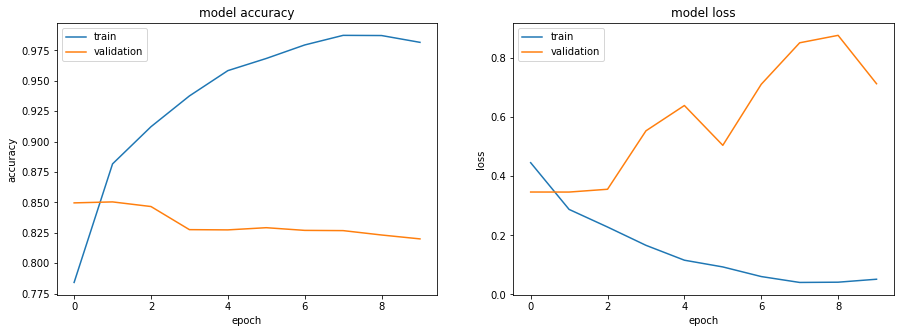

In [26]:
# plot the loss and the accuracy
plt.figure(figsize=(15,5))

gs = gridspec.GridSpec(1,2)

ax = plt.subplot(gs[0])
plot_accuracy(history_base_line)

ax = plt.subplot(gs[1])
plot_loss(history_base_line)

## Transfer the knowledge from the pretrained model

In [45]:
# load the pre-trained model 
model = load_model(PRETRAINED_MODEL)

In [46]:
print("Pretrained model summary: \n")
model.summary()

Pretrained model summary: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 1,379,590
Trainable params: 1,379,590
Non-trainable params: 0
_________________________________________________________________


In [47]:
def freeze_model(model):
    """ Freeze the weights of the model"""
    for l in model.layers:
        l.trainable = False 
    return model

In [48]:
# remove the last layer 
model.layers.pop()

# freeze the model 
model = freeze_model(model)

# add a new Dense layer for binary classification
model.add(Dense(1,activation='sigmoid'))

In [49]:
print("New model for sentiment analysis on IMDb: \n")
model.summary()

New model for sentiment analysis on IMDb: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 1,378,823
Trainable params: 7
Non-trainable params: 1,378,816
_________________________________________________________________


In [50]:
keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer, 
              'binary_crossentropy', 
              metrics=['accuracy'])

In [51]:
# train the model
history = model.fit(X, y,
          batch_size=BATCH_SIZE,
          epochs=NB_EPOCHS,
          validation_split=VAL_SPLIT)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 576us/step - loss: 0.6736 - acc: 0.6300 - val_loss: 0.5879 - val_acc: 0.8040
Epoch 2/10
20000/20000 [==============================] - 11s 548us/step - loss: 0.5312 - acc: 0.8087 - val_loss: 0.4753 - val_acc: 0.8072
Epoch 3/10
20000/20000 [==============================] - 11s 552us/step - loss: 0.4559 - acc: 0.8075 - val_loss: 0.4418 - val_acc: 0.8084
Epoch 4/10
20000/20000 [==============================] - 12s 585us/step - loss: 0.4405 - acc: 0.8109 - val_loss: 0.4339 - val_acc: 0.8106
Epoch 5/10
20000/20000 [==============================] - 12s 587us/step - loss: 0.4346 - acc: 0.8101 - val_loss: 0.4294 - val_acc: 0.8110
Epoch 6/10
20000/20000 [==============================] - 12s 588us/step - loss: 0.4326 - acc: 0.8095 - val_loss: 0.4267 - val_acc: 0.8106
Epoch 7/10
20000/20000 [==============================] - 12s 603us/step - loss: 0.4321 - acc: 0.8101 - val_loss: 0.4

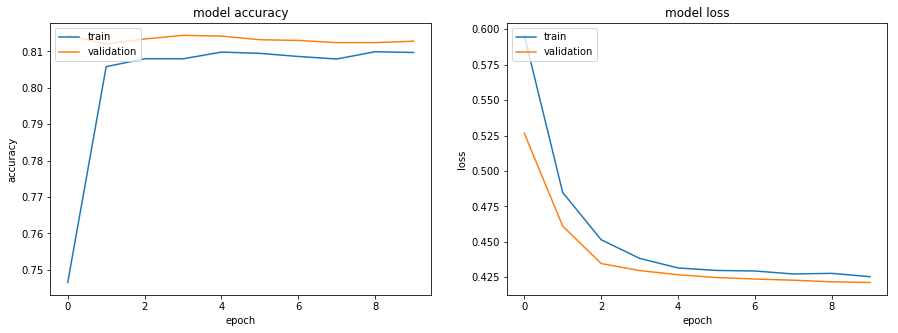

In [24]:
# plot the loss and the accuracy
plt.figure(figsize=(15,5))

gs = gridspec.GridSpec(1,2)

ax = plt.subplot(gs[0])
plot_accuracy(history)

ax = plt.subplot(gs[1])
plot_loss(history)

## Compare the results

In [30]:
X_test = text_to_seq(X_test, MAX_WORDS)
print("Test set shape: ", X.shape)

Test set shape:  (25000, 100)


In [64]:
print("Predict the labels on the test set...")
baseline_pred = base_line.predict_proba(X_test)
model_pred = model.predict(X_test)
print("Done")

Predict the labels on the test set...
Done


In [75]:
def plot_ROC(y_test, y_baseline, y_model):
    """ Plot the ROC curve to compare the two models: baseline and pretrained"""
    # Plot the baseline model
    auc_bl = roc_auc_score(y_test, y_baseline)

    print('Baseline AUC: %.3f' % auc_bl)
    # calculate roc curve
    fpr_bl, tpr_bl, thresholds_bl = roc_curve(y_test, y_baseline)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr_bl, tpr_bl, marker='.')

    auc_tl = roc_auc_score(y_test, y_model)
    # Plot the pretrained model
    print('Pretrained AUC: %.3f' % auc_tl)
    # calculate roc curve
    fpr_tl, tpr_tl, thresholds_tl = roc_curve(y_test, y_model)
    # plot the roc curve for the model
    plt.plot(fpr_tl, tpr_tl, marker="*")

Baseline AUC: 0.897
Pretrained AUC: 0.891


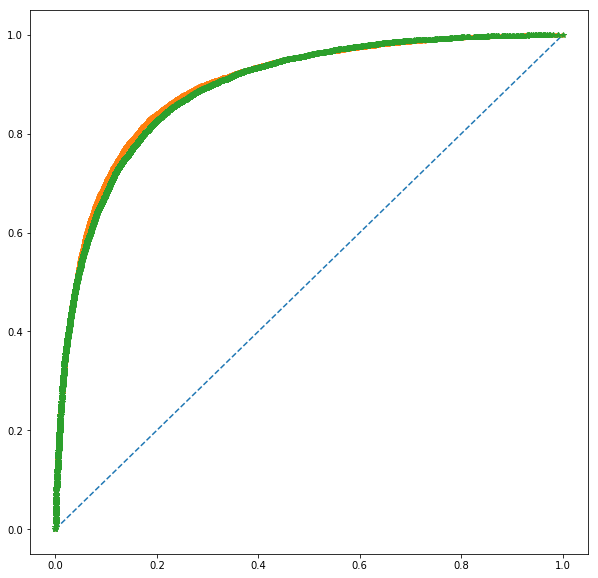

In [76]:
plt.figure(figsize=(10,10))
plot_ROC(y_test, baseline_pred, model_pred)